In [292]:
# !gdown --id 1BSHIKQ7rFw5BpTq5nw1UZfjPK_7Mpnbi
# !mv _sqlite3.cpython-37m-x86_64-linux-gnu.so /usr/lib/python3.7/lib-dynload/
# import os
# os.kill(os.getpid(), 9)

In [293]:
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [294]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy
import statsmodels.api as sm
import statsmodels.stats.proportion as proportion
import phik
import itertools
import collections
from copy import deepcopy
import sqlite3

In [295]:
sqlite3.sqlite_version

'3.38.0'

In [296]:
plt.style.use('dark_background')

In [297]:
con = sqlite3.connect('db')

# **Этап чтения и предобработки**

In [298]:
countries = pd.read_csv('/content/countries.csv')

In [299]:
df = pd.read_csv('/content/synthetic_data.csv')

In [300]:
# countries

In [301]:
countries.head()

,country,client_id
0,IN,6348826
1,FR,6751691
2,DE,8638448
3,LT,4722696
4,ES,2411132


In [302]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219314 entries, 0 to 219313
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   country    219314 non-null  object
 1   client_id  219314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [303]:
countries.isna().mean()

country      0.0
client_id    0.0
dtype: float64

In [304]:
countries['country'].unique()

array(['IN', 'FR', 'DE', 'LT', 'ES', 'VN', 'LU', 'US', 'IT', 'IS', 'MO'],
      dtype=object)

In [305]:
# df

In [306]:
df.head()

,Unnamed: 0,depo,segment,channel,clicks,latency,client_id
0,0,0,postid_4057,smm,1.0,2.649725,1442498
1,1,0,telegram,affiliate,10.0,2.610846,7865631
2,2,0,postid_8542,facebook,13.0,3.001162,8165584
3,3,0,telegram,direct,0.0,1.788369,5893056
4,4,0,telegram,smm,0.0,1.932069,3780924


In [307]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [308]:
df.columns

Index(['depo', 'segment', 'channel', 'clicks', 'latency', 'client_id'], dtype='object')

In [309]:
df.columns = ['deposit', 'segment', 'channel', 'click_per_first_day', 'ping', 'client_id']

In [310]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id
0,0,postid_4057,smm,1.0,2.649725,1442498
1,0,telegram,affiliate,10.0,2.610846,7865631
2,0,postid_8542,facebook,13.0,3.001162,8165584
3,0,telegram,direct,0.0,1.788369,5893056
4,0,telegram,smm,0.0,1.932069,3780924


In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219314 entries, 0 to 219313
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   deposit              219314 non-null  int64  
 1   segment              219314 non-null  object 
 2   channel              217142 non-null  object 
 3   click_per_first_day  219314 non-null  float64
 4   ping                 219314 non-null  float64
 5   client_id            219314 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 10.0+ MB


In [312]:
length = df.shape[0]

In [313]:
size = df.size

In [314]:
df.axes

[RangeIndex(start=0, stop=219314, step=1),
 Index(['deposit', 'segment', 'channel', 'click_per_first_day', 'ping',
        'client_id'],
       dtype='object')]

In [315]:
len(countries) ==  length

True

In [316]:
df = df.merge(countries, on = 'client_id', how = 'inner')

In [317]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id,country
0,0,postid_4057,smm,1.0,2.649725,1442498,IT
1,0,postid_4057,smm,1.0,2.649725,1442498,IT
2,0,telegram,affiliate,10.0,2.610846,7865631,LU
3,0,telegram,affiliate,10.0,2.610846,7865631,LU
4,0,postid_8542,facebook,13.0,3.001162,8165584,MO


In [318]:
df.dtypes

deposit                  int64
segment                 object
channel                 object
click_per_first_day    float64
ping                   float64
client_id                int64
country                 object
dtype: object

In [319]:
df['click_per_first_day'] = df['click_per_first_day'].astype('int')

In [320]:
def custom_hist(df : pd.Series):
  fig = plt.figure(figsize = (8, 8))
  ax = fig.add_subplot()
  plt.hist(df, color = 'red', edgecolor = 'skyblue', density = True, bins = 20)
  plt.axvline(np.mean(df), linestyle = 'dashed', linewidth = 2, label = 'average df', color = 'pink')
  plt.axvline(np.quantile(df, 0.25), linestyle = 'dashed', linewidth = 2, label = '0.25Procentile', color = 'green')
  plt.axvline(np.quantile(df, 0.75), linestyle = 'dashed', linewidth = 2, label = '0.75Procentile', color = 'green')
  sns.kdeplot(df, color = 'blue', alpha = 0.6)
  plt.title('Histogram')
  plt.xlabel('Values')
  plt.ylabel('Counter of values')
  plt.minorticks_on()
  plt.grid(which = 'minor', ls = '--', linewidth = 0.2)
  plt.show(); 

In [321]:
def describe_columns(df : pd.Series):
  print(f'Counter of nans : {df.isna().mean()}')
  print(f'Dtype : {df.dtypes}')
  print(f'Len Unique : {len(set(df.tolist()))}')

In [322]:
def select(sql):
  return pd.read_sql(sql,con)

In [323]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id,country
0,0,postid_4057,smm,1,2.649725,1442498,IT
1,0,postid_4057,smm,1,2.649725,1442498,IT
2,0,telegram,affiliate,10,2.610846,7865631,LU
3,0,telegram,affiliate,10,2.610846,7865631,LU
4,0,postid_8542,facebook,13,3.001162,8165584,MO


**deposit**

In [324]:
describe_columns(df['deposit'])

Counter of nans : 0.0
Dtype : int64
Len Unique : 810


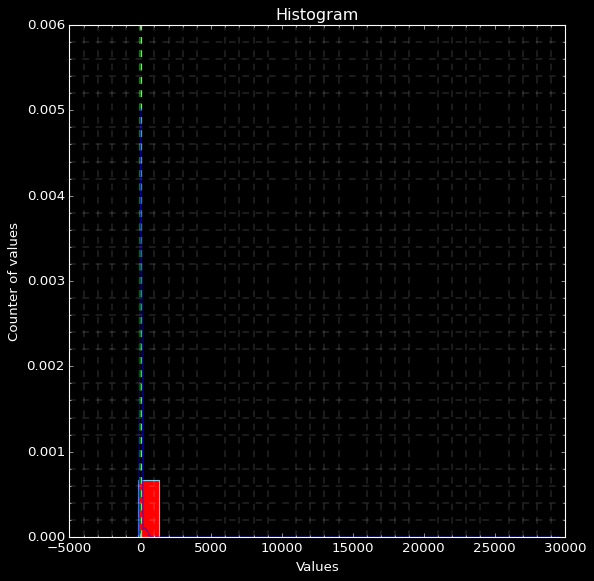

In [325]:
custom_hist(df['deposit']) # A lot of bad itmes

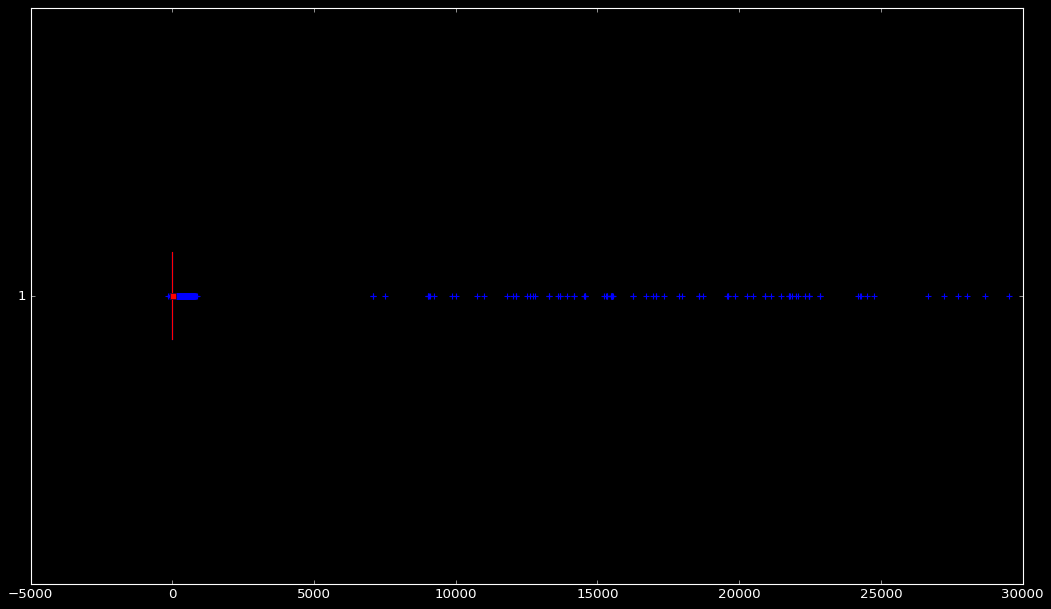

In [326]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot()
plt.boxplot(df['deposit'], vert = False, showmeans = True, sym = 'b+')
plt.show();


In [327]:
len(df.loc[df['deposit'] > 5 * 10 ** 3])

88

In [328]:
len(df.loc[df['deposit'] < 0])

94

In [329]:
df.loc[df['deposit'] < 0]

,deposit,segment,channel,click_per_first_day,ping,client_id,country
494,-3,telegram,social media,0,3.393788,5930737,LU
495,-3,telegram,social media,0,3.393788,5930737,LU
1788,-6,telegram,social media,4,1.906850,5131530,FR
1789,-6,telegram,social media,4,1.906850,5131530,FR
3552,-20,telegram,direct,31,2.078781,5818342,IN
...,...,...,...,...,...,...,...
210203,-31,telegram,affiliate,36,3.111986,7188598,IT
212756,-62,telegram,affiliate,40,3.000000,6488222,IT
213360,-18,telegram,social media,45,2.213038,1309043,LT
216144,-11,telegram,direct,34,3.812777,8125744,MO


In [330]:
 df = df.loc[df['deposit'] >= 0]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


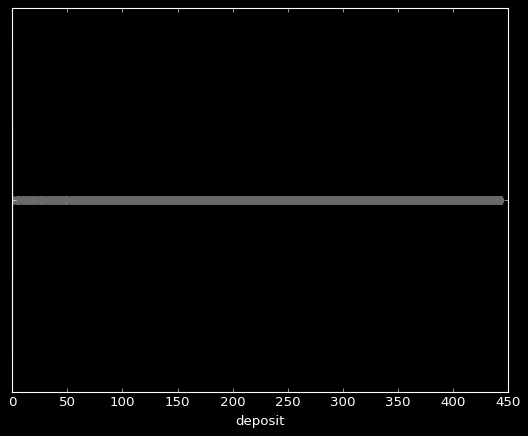

In [331]:
sns.boxplot(df.loc[df['deposit'].between(0, np.quantile(df['deposit'], 0.99))]['deposit'])

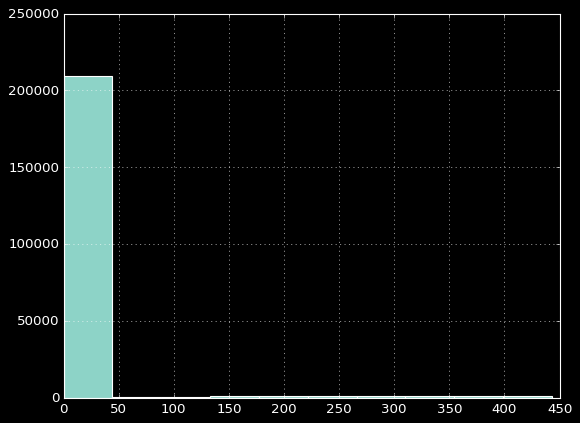

In [332]:
df.loc[df['deposit'].between(0, np.quantile(df['deposit'], 0.99))]['deposit'].hist()

In [333]:
df['deposit'].describe(include = 'all')

count    219220.000000
mean         21.370796
std         368.411761
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       29527.000000
Name: deposit, dtype: float64

In [334]:
df = df.loc[df['deposit'].between(0, np.quantile(df['deposit'], 0.99))]

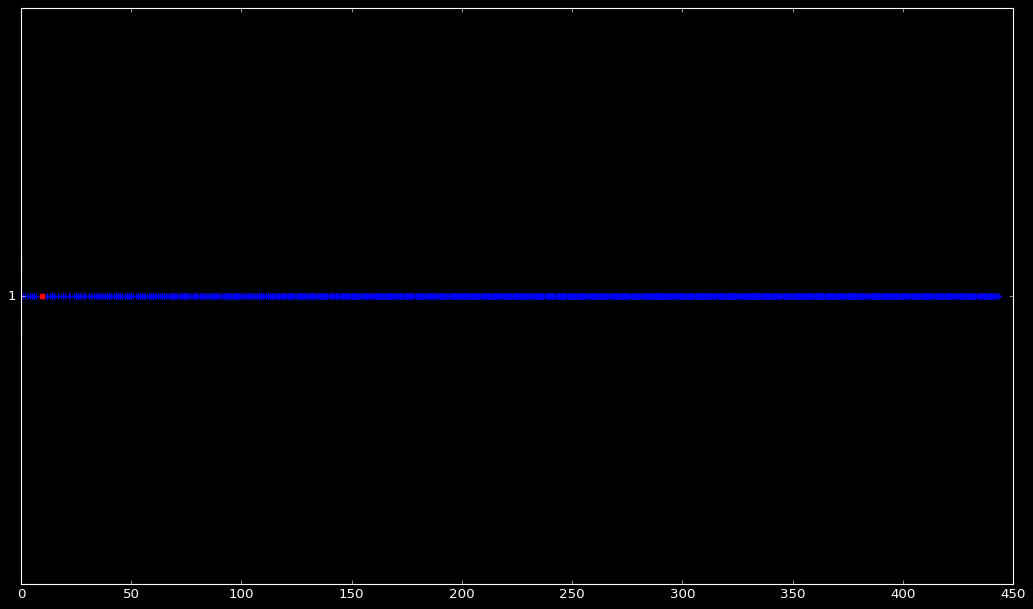

In [335]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot()
plt.boxplot(df['deposit'], vert = False, showmeans = True, sym = 'b+')
plt.show();

In [336]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id,country
0,0,postid_4057,smm,1,2.649725,1442498,IT
1,0,postid_4057,smm,1,2.649725,1442498,IT
2,0,telegram,affiliate,10,2.610846,7865631,LU
3,0,telegram,affiliate,10,2.610846,7865631,LU
4,0,postid_8542,facebook,13,3.001162,8165584,MO


**segment**

In [337]:
describe_columns(df['segment'])

Counter of nans : 0.0
Dtype : object
Len Unique : 9801


In [338]:
data = deepcopy(df)

In [339]:
df['segment'] = df['segment'].apply(lambda x: 'article' if 'postid' in str(x) else 'telegram') # Return article to post id

In [340]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id,country
0,0,article,smm,1,2.649725,1442498,IT
1,0,article,smm,1,2.649725,1442498,IT
2,0,telegram,affiliate,10,2.610846,7865631,LU
3,0,telegram,affiliate,10,2.610846,7865631,LU
4,0,article,facebook,13,3.001162,8165584,MO


In [341]:
data = deepcopy(df)

In [342]:
data.to_sql('depo',con,index=False,if_exists='replace')

In [343]:
sql = '''

select t.segment,
count(*) as cnt
from depo as t
group by t.segment

'''

In [344]:
select(sql)

,segment,cnt
0,article,155229
1,telegram,61801


**channel**

In [345]:
describe_columns(df.channel)

Counter of nans : 0.01027046952034281
Dtype : object
Len Unique : 6


In [346]:
df.loc[df['channel'].isnull()].head() # We are going to drop nans, beacause i dont wonna to make danger for data


,deposit,segment,channel,click_per_first_day,ping,client_id,country
444,0,article,NaN,0,3.513545,7775021,VN
445,0,article,NaN,0,3.513545,7775021,VN
552,0,telegram,NaN,1,3.813109,5505050,US
553,0,telegram,NaN,1,3.813109,5505050,US
1052,0,article,NaN,16,2.278295,1386781,MO


In [347]:
df = df.loc[~df['channel'].isnull()]

In [348]:
len(df) 


214801

**now check thew duplicates**

In [349]:
t = df.groupby('client_id')['ping'].agg(['count'])

In [350]:
t.loc[t['count'] > 1][:5]

,count
client_id,
1000408,2
1000853,2
1001045,2
1001051,2
1001101,2


In [351]:
df = df.drop_duplicates().reset_index(drop = True)

In [352]:
abs(len(df) - length)

65005

In [353]:
data = deepcopy(df)

In [354]:
data.to_sql('depo',con,index=False,if_exists='replace')

In [355]:
sql = '''
with a as (select t.client_id,
count(*) as cnt
from depo t
group by t.client_id)

select count(*)
from a
where a.cnt > 1 
'''

In [356]:
select(sql)

,count(*)
0,0


**click_per_first_day**

In [357]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id,country
0,0,article,smm,1,2.649725,1442498,IT
1,0,telegram,affiliate,10,2.610846,7865631,LU
2,0,article,facebook,13,3.001162,8165584,MO
3,0,telegram,direct,0,1.788369,5893056,US
4,0,telegram,smm,0,1.932069,3780924,FR


In [358]:
describe_columns(df['click_per_first_day'])

Counter of nans : 0.0
Dtype : int64
Len Unique : 51


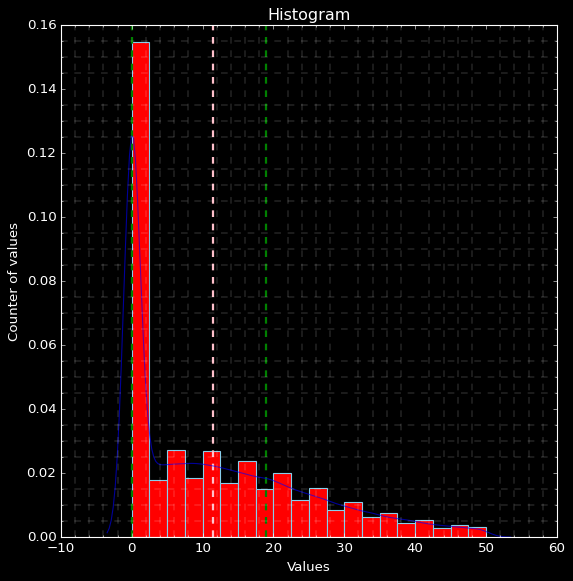

In [359]:
custom_hist(df['click_per_first_day'])

In [360]:
len(df.loc[df['click_per_first_day'] == 0]) / len(df) * 100 # 34.42637824106177 процентов пользователей не поользуются приложением после регистриации - это плохо

34.42637824106177

**ping**

In [361]:
describe_columns(df['ping'])

Counter of nans : 0.0
Dtype : float64
Len Unique : 153954


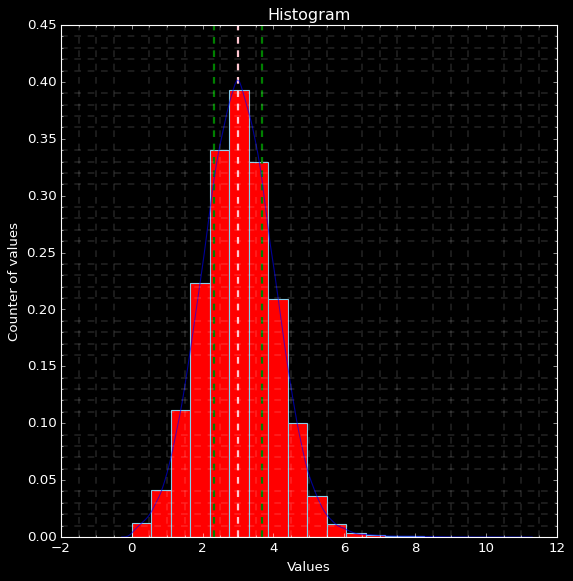

In [362]:
custom_hist(df['ping']) # Нормальое распределение

**-How users are distributed over countries?**

In [363]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id,country
0,0,article,smm,1,2.649725,1442498,IT
1,0,telegram,affiliate,10,2.610846,7865631,LU
2,0,article,facebook,13,3.001162,8165584,MO
3,0,telegram,direct,0,1.788369,5893056,US
4,0,telegram,smm,0,1.932069,3780924,FR


In [364]:
data = deepcopy(df)

In [365]:
data.to_sql('depo',con,index=False,if_exists='replace')

In [366]:
sql = '''
select t.country,
count(*) as cnt
from depo t
group by t.country
order by count(*) desc
'''

In [367]:
t = select(sql)

In [368]:
t # Распределено равномерно - провизуализируем это

,country,cnt
0,DE,14201
1,US,14150
2,ES,14136
3,IS,14102
4,VN,14088
5,LT,14065
6,FR,13983
7,MO,13949
8,IT,13914
9,IN,13893


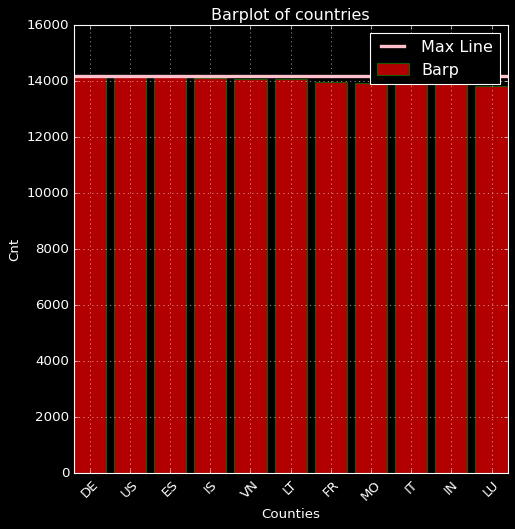

In [369]:
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot()
plt.bar(t['country'].values, t['cnt'], alpha = 0.7, 
          color = 'red', edgecolor = 'green', label = 'Barp')
plt.axhline(max(t['cnt']), color = 'pink', linewidth = 3, label = 'Max Line')
plt.legend(loc = 'best')
plt.title('Barplot of countries')
plt.xlabel('Counties')
plt.ylabel('Cnt')
plt.xticks(rotation = 45)
plt.grid()
plt.show();

**-How many outliers are there in data (in terms of deposits)?**

  Мы уже отработали выброси по deposit

  Отрцительные значения мы просто выбросили - чтобы не портить дальнейший анализ
  Были выбросы в виде слишком больших значений
  
  Их можно было определить в оделную группу, но мы их просто убрали чтобы не портить в будущем наш средний чек. Потому что он идет параллельно конверсии

**-Find segments with best conversion rate (client/lead ratio) and explain why you consider them best ones**

In [370]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id,country
0,0,article,smm,1,2.649725,1442498,IT
1,0,telegram,affiliate,10,2.610846,7865631,LU
2,0,article,facebook,13,3.001162,8165584,MO
3,0,telegram,direct,0,1.788369,5893056,US
4,0,telegram,smm,0,1.932069,3780924,FR


In [371]:
df['segment'].unique() 

array(['article', 'telegram'], dtype=object)

In [372]:
sql = '''
  with a as(select t.*,
  case when t.deposit > 0 then 1 else 0 end as b_depo

  from depo as t)

  select t.segment,
  t.channel,
  avg(t.b_depo) as conversion,
  avg(t.deposit) as average_cheque
  from a as t
  group by t.segment, t.channel
  order by t.deposit desc
'''

In [373]:
select(sql)

,segment,channel,conversion,average_cheque
0,article,affiliate,0.027838,9.175946
1,article,direct,0.025461,8.595502
2,article,facebook,0.038750,12.683552
3,article,smm,0.024695,8.178678
4,article,social media,0.000000,0.000000
5,telegram,affiliate,0.074833,15.663252
6,telegram,direct,0.059784,12.243734
7,telegram,facebook,0.033086,6.802692
8,telegram,smm,0.095570,19.337539
9,telegram,social media,0.061558,12.541135


In [374]:
# Тот же самый код но на питоне - лично мне проще просто делать агрегацию через sql

In [375]:
df['b_depo'] = df['deposit'].apply(lambda x: 1 if x > 0 else 0)

In [376]:
df.groupby(['segment', 'channel']).agg({'deposit' : 'mean', 'b_depo' : 'mean'}).sort_values('b_depo', ascending = False).\
            reset_index().rename(columns = {'deposit' : 'average_bil', 'b_depo' : 'conversion'})

,segment,channel,average_bil,conversion
0,telegram,smm,19.337539,0.095570
1,telegram,affiliate,15.663252,0.074833
2,telegram,social media,12.541135,0.061558
3,telegram,direct,12.243734,0.059784
4,article,facebook,12.683552,0.038750
5,telegram,facebook,6.802692,0.033086
6,article,affiliate,9.175946,0.027838
7,article,direct,8.595502,0.025461
8,article,smm,8.178678,0.024695
9,article,social media,0.000000,0.000000


**Пока что делать выводы рано, но скорее всего в телеграм идет гораздо меньше 
  денег чем artice, но его конверсия и средний чек показывают гораздо более лучшие результаты. Мы тут не учитываем количество, потому что выборку можно назвать репрезентативной ибо в кажой примерно более двух тысяч. Остается рассмотреть как между собой распределяются article and segment, и сделать вывод исходя из этого**

In [377]:
def two_barplots(df : pd.DataFrame, segment_columns : list):
  grouped_telegram = df.loc[df['segment'] == segment_columns[0]].groupby('channel')['deposit'].agg(['count']).\
        reset_index()
  grouped_article = df.loc[df['segment'] == segment_columns[1]].groupby('channel')['deposit'].agg(['count']).\
        reset_index()
  plt.style.use('classic')
  fig = plt.figure(figsize = (16, 9))
  ax = fig.add_subplot()
  plt.bar(grouped_telegram['channel'].values, grouped_telegram['count'].values,
                        alpha = 0.6, label = 'Barp Telegram', color = 'green')
  plt.bar(grouped_article['channel'].values, grouped_article['count'].values,
                        alpha = 0.6, label = 'Barp article', color = 'pink')
  plt.title('2 Barp Article,Telegram')
  plt.xlabel('Channels')
  plt.grid()
  plt.legend(loc = 'best')
  plt.show();

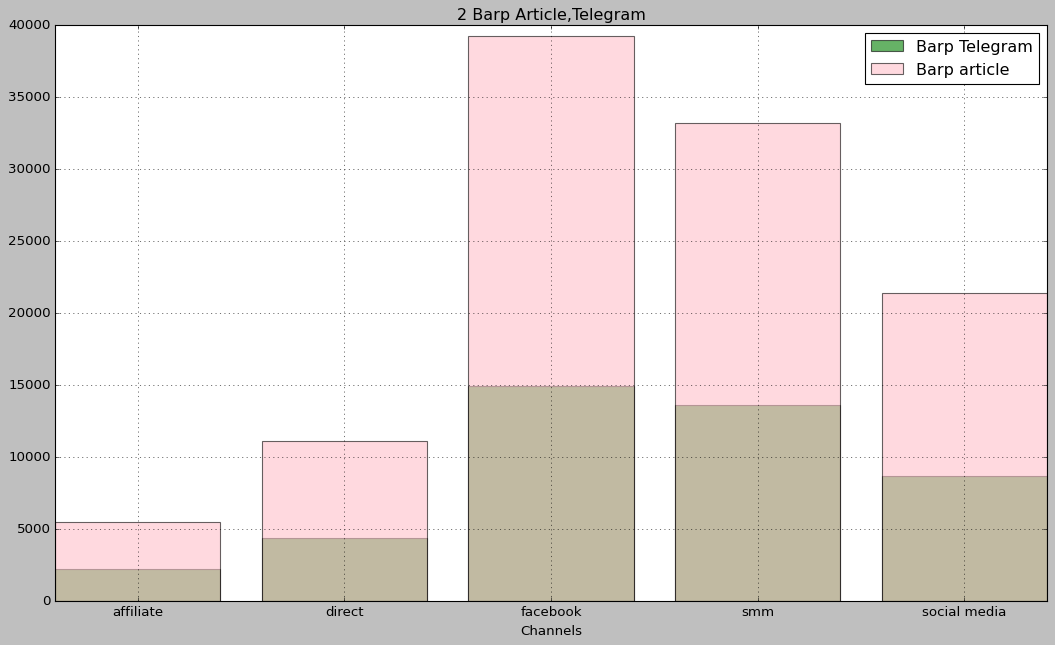

In [378]:
two_barplots(df, ['telegram', 'article'])

**Исходя из результатов, очевидно что если предположить что есть корелляция между количество вложенных средств и количеством регистраций, то в таком случае в письма вкладывают гораздо больше чем в телеграм каналы, но очевидно что при этом телеграм каналы показывают очень хорошая конверсию в лида, и с очень благоприятным средним чеком.

Лично я бы предположил провести АБ тест, в котором в следующий месяц
рапределние средств в рекламу пойдет больше в телеграм, нежели в article.
На данный момент если судить по выборке, то 30 процентов приходят из телеграм каналов, но при это если мы рассуждаем что есть прямая зависимость между вложенными средствами и количество регистраций, то если мы поменяем местами article, telegam, а после чего проверим гипотезу о том что в таком случае у нас 
объем продаж возрасет. То можно толтко в таком случае судит о приемуществах telegam каналов.** **Текст, выделенный полужирным шрифтом**

**click_per_first_day - проверка Retention**

In [383]:
df.head()

,deposit,segment,channel,click_per_first_day,ping,client_id,country,b_depo
0,0,article,smm,1,2.649725,1442498,IT,0
1,0,telegram,affiliate,10,2.610846,7865631,LU,0
2,0,article,facebook,13,3.001162,8165584,MO,0
3,0,telegram,direct,0,1.788369,5893056,US,0
4,0,telegram,smm,0,1.932069,3780924,FR,0


In [384]:
len(df.loc[df['click_per_first_day'] == 0]) / len(df) * 100

34.42637824106177

**Мне не очень нравится метрика в которой у нас 34 процента пользователей не используют приложение в дальнейшем после регистрации. Если предположить что по сути акивность должна проявляться в первые дни регистрации, то это очень плохо.Я бы изучил зависимость между количеством кликов и внесенными депозитами.
Если мы сможем увидеть связь, тогда стоит делать некоторые выводы.**

In [387]:
df['deposit'].corr(df['click_per_first_day']) # 0.6% Все что ниже 0.19 нет смысла рассматривать - построим scatter plot чтобы посмотреть на расрпеделния двух велеичин

0.0067524010173854775

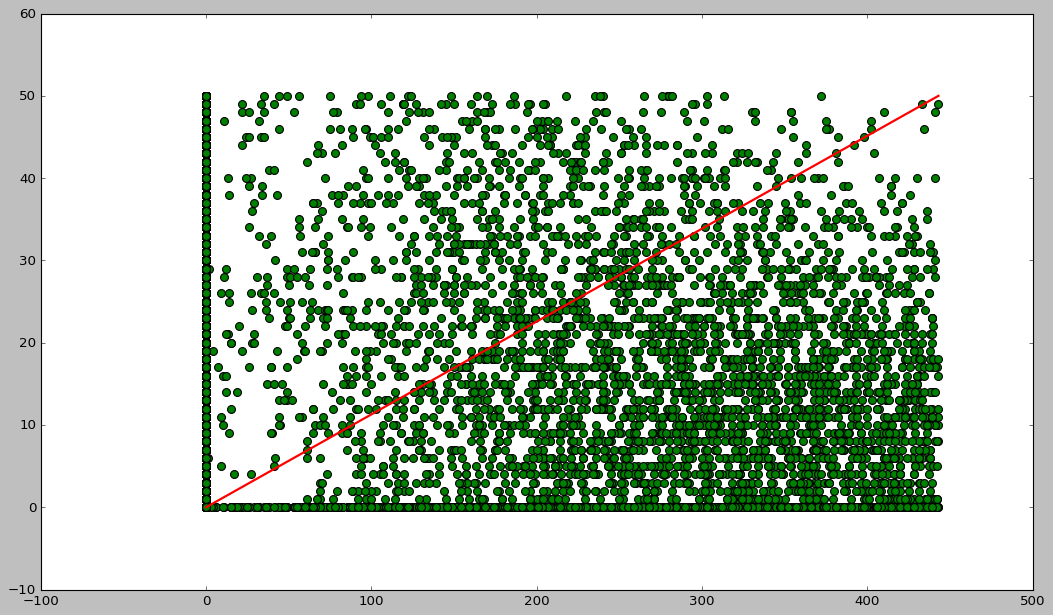

In [391]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot()
plt.scatter(df['deposit'], df['click_per_first_day'], s = 50, c = 'green',
            edgecolor = 'black')
plt.plot([0, max(df['deposit'])], [0, max(df['click_per_first_day'])], linewidth = 2, color = 'red')
plt.show();

**Очевидно что нет линейной зависимости между двумя этими столбцами, но лично мне все не нравится показатель в 34 процента. Я бы передал это отделу проуктовой аналитики. Чтобы они провели АБ тесты и смогли улучшить этот показатель (Retention)**